In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

import os
import sys

# Enables the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
# Effective when input sizes for the network do not vary.
cudnn.benchmark = True

plt.ion()   # interactive mode

import warnings
# filter warnings
warnings.filterwarnings('ignore')


In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name())
else:
    print("⚠️ GPU is NOT active! Go to Runtime → Change runtime type → GPU")


CUDA available: False
⚠️ GPU is NOT active! Go to Runtime → Change runtime type → GPU


In [12]:
# Визначаємо DATA_ROOT залежно від середовища
if 'google.colab' in sys.modules:
    # from google.colab import drive
    # drive.mount('/content/drive')

    DATA_ROOT = "/content/drive/MyDrive/Neoversity_Woolf/DeepLearning/Module_3_Topic_6_hymenoptera_data"  # <-- підстав свій шлях
else:
    DATA_ROOT = os.path.join(os.getcwd(), "Module_3_Topic_6_hymenoptera_data")

train_dir = os.path.join(DATA_ROOT, "train")
test_dir  = os.path.join(DATA_ROOT, "val")

print("Train dir:", train_dir)
print("Test dir:", test_dir)

# Далі вже, наприклад:
# from torchvision import datasets, transforms
# train_dataset = datasets.ImageFolder(train_dir, transform=...)
# test_dataset = datasets.ImageFolder(test_dir, transform=...)

Train dir: /Users/oleksandrnovokhatskyi/Documents/Neovercity_Woolf/Deep_Learning/Deep_learning/topic 5_6/Module_3_Topic_6_hymenoptera_data/train
Test dir: /Users/oleksandrnovokhatskyi/Documents/Neovercity_Woolf/Deep_Learning/Deep_learning/topic 5_6/Module_3_Topic_6_hymenoptera_data/val


In [13]:
print("CWD:", os.getcwd())
print(os.listdir("."))

CWD: /Users/oleksandrnovokhatskyi/Documents/Neovercity_Woolf/Deep_Learning/Deep_learning/topic 5_6
['Module_3_Topic_6_hymenoptera_data', 'transfer_learning.ipynb', 'lecture_5.ipynb', '.DS_Store', 'Module_3_Topic_6_hymenoptera_data.zip']


In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [15]:
import os
print(os.path.exists(train_dir))

True


In [16]:
data_dir = DATA_ROOT
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

print(image_datasets['train'].classes)
print(len(image_datasets['train']))

['ants', 'bees']
244


In [17]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}


In [18]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


{'train': 244, 'val': 153}
['ants', 'bees']
Using device: cpu


In [19]:
# Let's create a function to display examples.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


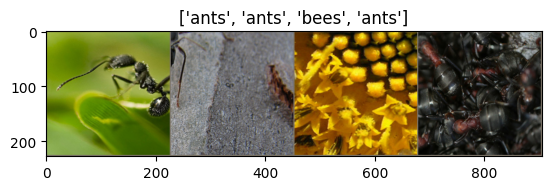

In [20]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
				
				# save model 
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


### Training all weights of the model

In [25]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001)

model_ft = train_model(model_ft, 
                    criterion, 
                    optimizer_ft,
                    scheduler=None,  
                    num_epochs=5
            )



Epoch 1/5
----------
train Loss: 0.6225 Acc: 0.6516
val Loss: 0.4250 Acc: 0.8562

Epoch 2/5
----------
train Loss: 0.4919 Acc: 0.7705
val Loss: 0.3114 Acc: 0.8889

Epoch 3/5
----------
train Loss: 0.4446 Acc: 0.8033
val Loss: 0.2570 Acc: 0.9216

Epoch 4/5
----------
train Loss: 0.3859 Acc: 0.8402
val Loss: 0.2272 Acc: 0.9216

Epoch 5/5
----------
train Loss: 0.3774 Acc: 0.8361
val Loss: 0.2202 Acc: 0.9216

Training complete in 4m 30s
Best val Acc: 0.921569


### Training only the classification layer

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)
model_conv = train_model(model_conv, 
                    criterion, 
                    optimizer_conv,
                    scheduler=None,  
                    num_epochs=5
            )

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/oleksandrnovokhatskyi/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:05<00:00, 4.04MB/s]


AttributeError: 'EfficientNet' object has no attribute 'fc'

In [28]:
# 1. Завантажуємо модель
model_conv = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# 2. Заморожуємо всі параметри (feature extractor)
for param in model_conv.parameters():
    param.requires_grad = False

# 3. Дістаємо кількість вхідних фіч у останнього Linear
num_ftrs = model_conv.classifier[1].in_features

# 4. Замінюємо останній Linear на наш (2 класи)
model_conv.classifier[1] = nn.Linear(num_ftrs, 2)

# 5. На девайс, лосс, оптимізатор
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.classifier[1].parameters(), lr=0.001)

# 6. Тренування
model_conv = train_model(
    model_conv,
    criterion,
    optimizer_conv,
    scheduler=None,
    num_epochs=5
)

Epoch 1/5
----------
train Loss: 0.6251 Acc: 0.6107
val Loss: 0.4207 Acc: 0.8824

Epoch 2/5
----------
train Loss: 0.4940 Acc: 0.7787
val Loss: 0.3177 Acc: 0.8889

Epoch 3/5
----------
train Loss: 0.4076 Acc: 0.8115
val Loss: 0.2558 Acc: 0.9281

Epoch 4/5
----------
train Loss: 0.4094 Acc: 0.8238
val Loss: 0.2373 Acc: 0.9085

Epoch 5/5
----------
train Loss: 0.3982 Acc: 0.8320
val Loss: 0.2246 Acc: 0.9281

Training complete in 5m 46s
Best val Acc: 0.928105
